In [1]:
import functools as ft
import time

import sys
import os
import numpy as np
import torch
import kornia.filters as kfilts
import xarray as xr
import pytorch_lightning as pl

from ocean4dvarnet.data import BaseDataModule, TrainingItem
from ocean4dvarnet.models import Lit4dVarNet

/Odyssey/private/rfablet/miniforge3/envs/fdv/lib/python3.10/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [2]:
tgt_path ='/SCRATCH/rfablet/Dataset/glorys12_2010_2019_daily_sla_4th.nc' #/Odyssey/public/glorys/reanalysis/glorys12_2010_2019_daily_sla_4th.nc #glorys4_2010_2019_sla.nc
inp_path = '/SCRATCH/rfablet/Dataset/glorys12_2010_2019_daily_sla_4th_input.nc'
tgt_var = 'sla'
inp_var = 'sla'

isel1 = dict(time=slice('2010-01-01', '2019-12-31'))
isel2 = dict(time=slice('2018-01-01', '2019-12-31'))

tgt1 = xr.open_dataset(tgt_path)[tgt_var].sel(isel1)
tgt2 = xr.open_dataset(tgt_path)[tgt_var].sel(isel2)

In [ ]:
isel = dict(time=slice('2018-01-01', '2019-12-31'))

sla_glorys = xr.open_dataset(tgt_path)[tgt_var].sel(isel)
obs_glorys = xr.open_dataset(inp_path)[inp_var].sel(isel)

sla_glorys.to_netcdf("/SCRATCH/rfablet/Dataset/glorys12_2010_2019_daily_sla_4th_2018-2019.nc")
obs_glorys.to_netcdf("/SCRATCH/rfablet/Dataset/glorys12_2010_2019_daily_sla_4th_input_2018-2019.nc")

In [3]:
isel = dict(time=slice('2018-01-01', '2019-12-31'), time2=slice('2018-01-01', '2019-12-31'))

isel

{'time': slice('2018-01-01', '2019-12-31', None),
 'time2': slice('2018-01-01', '2019-12-31', None)}

In [ ]:
sla_glorys = xr.open_dataset("/SCRATCH/rfablet/Dataset/glorys12_2010_2019_daily_sla_4th_2018-2019.nc")[tgt_var].sel(isel)
obs_glorys = xr.open_dataset("/SCRATCH/rfablet/Dataset/glorys12_2010_2019_daily_sla_4th_input_2018-2019.nc")[tgt_var].sel(isel)

In [4]:
def load_glorys12_data(tgt_path, inp_path, tgt_var="zos", inp_var="input"):
    isel = None  # dict(time=slice(-465, -265))

    _start = time.time()

    print('..... Start loading dataset',flush=True)
    
    tgt = (
        xr.open_dataset(tgt_path)[tgt_var]
        .isel(isel)
    )
    inp = xr.open_dataset(inp_path)[inp_var].isel(isel)

    ds = (
        xr.Dataset(
            dict(input=inp, tgt=(tgt.dims, tgt.values)),
            inp.coords,
        )
        .to_array()
        .sortby("variable")
    )

    print(f">>> Durée de chargement : {time.time() - _start:.4f} s",flush=True)
    #print(ds,flush=True)

    #print(ds["tgt"].data,flush=True)

    return ds

In [5]:
tgt_path ='/SCRATCH/rfablet/Dataset/glorys12_2010_2019_daily_sla_4th.nc' #/Odyssey/public/glorys/reanalysis/glorys12_2010_2019_daily_sla_4th.nc #glorys4_2010_2019_sla.nc
inp_path = '/SCRATCH/rfablet/Dataset/glorys12_2010_2019_daily_sla_4th_input.nc'

tgt_path ='/SCRATCH/rfablet/Dataset/glorys12_2010_2019_daily_sla_4th_2018-2019.nc' #/Odyssey/public/glorys/reanalysis/glorys12_2010_2019_daily_sla_4th.nc #glorys4_2010_2019_sla.nc
inp_path = '/SCRATCH/rfablet/Dataset/glorys12_2010_2019_daily_sla_4th_input_2018-2019.nc'

#os.chdir('./contrib/glorys12/')
ds = load_glorys12_data(tgt_path, inp_path, tgt_var="sla", inp_var="sla")

..... Start loading dataset
>>> Durée de chargement : 5.7619 s


In [6]:
from ocean4dvarnet.data import BaseDataModule, TrainingItem

class DistinctNormDataModule(BaseDataModule):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.input_mask = None

        if isinstance(self.input_da, (tuple, list)):
            self.input_da, self.input_mask = self.input_da[0], self.input_da[1]

    def norm_stats(self):
        if self._norm_stats is None:
            raise NormParamsNotProvided()
        return self._norm_stats

    def post_fn(self, phase):
        m, s = self.norm_stats()[phase]

        def normalize(item):
            return (item - m) / s

        return ft.partial(
            ft.reduce,
            lambda i, f: f(i),
            [
                TrainingItem._make,
                lambda item: item._replace(tgt=normalize(item.tgt)),
                lambda item: item._replace(input=normalize(item.input)),
            ],
        )


    def setup(self, stage="test"):
        self.train_ds = LazyXrDataset(
            self.input_da.sel(self.domains["train"]),
            **self.xrds_kw["train"],
            postpro_fn=self.post_fn("train"),
            mask=self.input_mask,
        )

        self.val_ds = LazyXrDataset(
            self.input_da.sel(self.domains["val"]),
            **self.xrds_kw["val"],
            postpro_fn=self.post_fn("val"),
            mask=self.input_mask,
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val_ds,
            shuffle=False,
            batch_size=1,
            num_workers=1,
        )

class LazyXrDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        ds,
        patch_dims,
        domain_limits=None,
        strides=None,
        postpro_fn=None,
        noise_type=None,
        noise=None,
        noise_spatial_perturb=None,
        *args,
        **kwargs,
    ):
        super().__init__()
        self.return_coords = False
        self.postpro_fn = postpro_fn
        self.ds = ds.sel(**(domain_limits or {}))
        self.patch_dims = patch_dims
        self.strides = strides or {}
        _dims = ("variable",) + tuple(k for k in self.ds.dims)
        _shape = (2,) + tuple(self.ds[k].shape[0] for k in self.ds.dims)
        ds_dims = dict(zip(_dims, _shape))
        # ds_dims = dict(zip(self.ds.dims, self.ds.shape))
        self.ds_size = {
            dim: max(
                (ds_dims[dim] - patch_dims[dim]) // strides.get(dim, 1) + 1,
                0,
            )
            for dim in patch_dims
        }
        self._rng = np.random.default_rng()
        self.noise = noise
        self.noise_spatial_perturb = noise_spatial_perturb

        if noise_type is not None:
            self.noise_type = noise_type
        else:
            self.noise_type = 'uniform-constant'

        self.mask = kwargs.get("mask")

    def __len__(self):
        size = 1
        for v in self.ds_size.values():
            size *= v
        return size

    def __iter__(self):
        for i in range(len(self)):
            yield self[i]

    def get_coords(self):
        self.return_coords = True
        coords = []
        try:
            for i in range(len(self)):
                coords.append(self[i])
        finally:
            self.return_coords = False
            return coords

    def __getitem__(self, item):
        sl = {}
        _zip = zip(
            self.ds_size.keys(), np.unravel_index(item, tuple(self.ds_size.values()))
        )

        for dim, idx in _zip:
            sl[dim] = slice(
                self.strides.get(dim, 1) * idx,
                self.strides.get(dim, 1) * idx + self.patch_dims[dim],
            )

        if self.mask is not None:
            start, stop = sl["time"].start % 365, sl["time"].stop % 365
            if start > stop:
                start -= stop
                stop = None
            sl_mask = sl.copy()
            sl_mask["time"] = slice(start, stop)

            da = self.ds.isel(**sl)

            item = (
                da.to_dataset(name="tgt")
                .assign(input=da.where(self.mask.isel(**sl_mask).values))
                .to_array()
                .sortby("variable")
            )
        else:
            item = self.ds.isel(**sl)

        if self.return_coords:
            return item.coords.to_dataset()[list(self.patch_dims)]

        item = item.data.astype(np.float32)

        #if self.noise:
        #    noise = np.tile(
        #        self._rng.uniform(-self.noise, self.noise, item[0].shape), (2, 1, 1, 1)
        #    ).astype(np.float32)
        #    item = item + noise

        if self.noise is not None:

            if self.noise_type ==  'uniform-constant' :
                #noise =  self._rng.uniform(-self.noise, self.noise, item[0].shape).astype(np.float32)
                #item[0] = item[0] + noise
                noise =  self._rng.uniform(-self.noise, self.noise, item.shape).astype(np.float32)

                item = item + noise
            elif self.noise_type ==  'gaussian+uniform' :
                scale = self._rng.uniform(0. , self.noise, 1).astype(np.float32)
                noise = self._rng.normal(0., 1. , item[0].shape).astype(np.float32)

                item[0] = item[0] + scale * noise
            elif self.noise_type ==  'spatial-perturb' :
                # patch dimensions
                N = item[0].shape[1]
                M = item[0].shape[2]
                T = item[0].shape[0]

                # parameters of the Gaussian Process
                L = 5.0  # Spatial correlation length
                T_corr = 20.0  # Temporal correlation length
                sigma  = self._rng.uniform(0. , self.noise_spatial_perturb, 1).astype(np.float32)

                # generate space-time random perturbations
                w  = np.matmul( np.hanning( N ).reshape(N,1) , np.hanning( M ).reshape(1,M) )
                dx = w * generate_correlated_fields_np(N, M, L, T_corr, sigma,T)
                dy = w * generate_correlated_fields_np(N, M, L, T_corr, sigma,T)

                # compute warped fields from reference field and associated error map
                warped_field = np.zeros_like(field)

                # Perform warping
                for ii in range(T):
                    warped_field[ii,:,:] = warp_field_np(item[1][ii,:,:], dx[ii,:,:], dy[ii,:,:])
                
                # residual error
                error = item[1][ii,:,:] - warped_field

                # apply mask
                noise = np.where( np.isnan(item[0]) , np.nan, error )
                print("..... std of the simulated noise : %.3f"%np.nanstd(noise) )
                
                # adding a white noise
                scale  = self._rng.uniform(0. , self.noise, 1).astype(np.float32)
                wnoise = scale * self._rng.normal(0., 1. , item[0].shape).astype(np.float32)

                item[0] = item[0] + noise + wnoise

        if self.postpro_fn is not None:
            return self.postpro_fn(item)
        return item


In [41]:
domain = dict(train= dict(time=slice('2018-01-01', '2018-12-31')),
               val= dict(time=slice('2019-01-01', '2019-12-31')))

xrds_kw = dict(train=dict(patch_dims=dict(time=15,lat=232,lon=366),
                          strides=dict(time=1,lat=224,lon=358),
                          domain_limits=domain['train']),
                val=dict(patch_dims=dict(time=15,lat=680,lon=1440),
                          strides=dict(time=1,lat=1,lon=1),
                          domain_limits=domain['train']),)
               

dl_kw = dict(batch_size=16, num_workers=1)
norm_stats = dict(train=[-0.001930378327255099,0.08604745118775728],
                  val=[0.01560162689028551, 0.08583080433051968])

xrds_kw
dl_kw
norm_stats

{'train': [-0.001930378327255099, 0.08604745118775728],
 'val': [0.01560162689028551, 0.08583080433051968]}

In [42]:
dm = DistinctNormDataModule(ds,domains=domain,xrds_kw=xrds_kw,dl_kw=dl_kw,norm_stats=norm_stats)

In [43]:
dm.setup()

In [44]:
dm.train_dataloader()
len( dm.train_dataloader())
#next(iter(dm.train_dataloader()))

264

In [46]:
dm.setup(stage='val')
dm.val_dataloader()

len( dm.val_dataloader())

0

In [ ]:
nc_file = '/SCRATCH/rfablet/Dataset/duacs_2010_2019_0.25deg.nc'
nc_file = '/SCRATCH/rfablet/Dataset/glorys12_2010_2019_daily_sla_4th.nc'
nc_file = '/SCRATCH/rfablet/Dataset/glorys12_2010_2019_daily_sla_4th_input.nc'
nc_file = '/SCRATCH/rfablet/Dataset/glorys12_2010_2019_daily_sla_4th_input.nc'

nc_file = '/Odyssey/public/altimetry_traces/2010_2019/gridded_0.25deg/sla_l3_all_2010_2019_0.25deg_convl4.nc'

nc_file = '/Odyssey/public/duacs/2010_2019/duacs_2010_2019_0.125deg.nc'


nc_file = '/Odyssey/public/glorys/reanalysis/glorys12_2010_2019_daily_sla_8th_input.nc'


isel1 = dict(time=slice('2010-01-01', '2019-12-31'))
ds = xr.open_dataset(nc_file, chunks = ({'time': 365, 'lat': 1500, 'lon': 3000})).sel(isel1)


# Convertir les variables 'time' et 'sla' en float32
ds['sla'] = ds['sla'].astype('float32')
ds['sla'].encoding.update(zlib=True, complevel=0)

nc_file_float32 = nc_file.replace('.nc','_float32.level0.nc')
nc_file_float32 = nc_file_float32.replace('/Odyssey/public/glorys/reanalysis/','/SCRATCH/rfablet/Dataset/')
print('Saving started',nc_file_float32 )
ds.to_netcdf(nc_file_float32 )

Saving started /SCRATCH/rfablet/Dataset/glorys12_2010_2019_daily_sla_8th_input.nc


In [2]:
nc_file = '/Odyssey/public/glorys/reanalysis/glorys12_2010_2019_daily_sla_8th_input.nc'
isel1 = dict(time=slice('2010-01-01', '2019-12-31'))
ds = xr.open_dataset(nc_file, chunks = ({'time': 365, 'lat': 1500, 'lon': 3000})).sel(isel1)

ds

<xarray.Dataset> Size: 109GB
Dimensions:    (time: 3652, latitude: 1296, longitude: 2880)
Coordinates:
  * time       (time) datetime64[ns] 29kB 2010-01-01 2010-01-02 ... 2019-12-31
  * latitude   (latitude) float32 5kB -80.0 -79.88 -79.75 ... 81.62 81.75 81.88
  * longitude  (longitude) float32 12kB -180.0 -179.9 -179.8 ... 179.8 179.9
Data variables:
    sla        (time, latitude, longitude) float64 109GB dask.array<chunksize=(365, 1296, 2880), meta=np.ndarray>
Attributes:
    description:  Glorys12v1 dataset regridded to eighth resolution and inter...

In [10]:
nc_file_float32 = nc_file.replace('.nc','_float32.nc')

isel = dict(time=slice('2010-01-01', '2019-12-31'))
ds1 = xr.open_dataset(nc_file).sel(isel)
ds2 = xr.open_dataset(nc_file_float32).sel(isel)

print('..... Difference between float64 and float32 file :',np.nanmax( np.abs(ds1['sla'].values - ds2['sla'].values) ))

..... Difference between float64 and float32 file : 1.1153852508272166e-07


In [4]:
nc_file = '/Odyssey/public/altimetry_traces/2010_2019/gridded_0.25deg/sla_l3_all_2010_2019_0.25deg_convl4.nc'
nc_file_float32 = '/Odyssey/public/altimetry_traces/2010_2019/gridded_0.25deg/sla_l3_all_2010_2019_0.25deg_convl4_float32.nc'

nc_file = '/Odyssey/public/altimetry_traces/2010_2019/gridded_0.125deg/sla_l3_all_2010_2019_0.125deg_convl4.nc'
nc_file_float32 = '/Odyssey/public/altimetry_traces/2010_2019/gridded_0.125deg/sla_l3_all_2010_2019_0.125deg_convl4_float32.nc'

isel = dict(time=slice('2010-01-01', '2010-12-31'))
ds1 = xr.open_dataset(nc_file).sel(isel)
ds2 = xr.open_dataset(nc_file_float32).sel(isel)

print('..... Difference between float64 and float32 file :',np.nanmax( np.abs(ds1['sla'].values - ds2['sla'].values) ))


..... Difference between float64 and float32 file : 5.91278075390278e-08


In [3]:
dir = '/Odyssey/private/rfablet/Python/4dvarnet-global-mapping'
os.chdir(dir)

In [ ]:
 #time: ['2018-12-01', '2019-03-31']
  #time: ['2019-03-15', '2019-07-31']
  #time: ['2019-07-15', '2019-10-31']
  time: ['2019-10-15', '2020-01-31']

In [43]:
nc_file_1 = 'inference/output/unet+-run2-8th-best-to8th-1.nc'
nc_file_2 = 'inference/output/unet+-run2-8th-best-to8th-2.nc'
nc_file_3 = 'inference/output/unet+-run2-8th-best-to8th-3.nc'
nc_file_4 = 'inference/output/unet+-run2-8th-best-to8th-4.nc'

nc_file_1 = 'inference/output/unet-run2-4th-best-to8th-1.nc'
nc_file_2 = 'inference/output/unet-run2-4th-best-to8th-2.nc'
nc_file_3 = 'inference/output/unet-run2-4th-best-to8th-3.nc'
nc_file_4 = 'inference/output/unet-run2-4th-best-to8th-4.nc'


isel1 = dict(time=slice('2019-01-01', '2019-03-15'))
isel2 = dict(time=slice('2019-03-16', '2019-07-15'))
isel3 = dict(time=slice('2019-07-16', '2019-10-15'))
isel4 = dict(time=slice('2019-10-16', '2019-12-31'))

ds1 = xr.open_dataset(nc_file_1).sel(isel1)
ds2 = xr.open_dataset(nc_file_2).sel(isel2)
ds3 = xr.open_dataset(nc_file_3).sel(isel3)
ds4 = xr.open_dataset(nc_file_4).sel(isel4)

In [ ]:
sla_all = np.concatenate((ds1['sla'].values, ds2['sla'].values, ds3['sla'].values, ds4['sla'].values), axis=0)
time_all = np.concatenate((ds1['time'].values, ds2['time'].values, ds3['time'].values, ds4['time'].values), axis=0)

ds_all = ds = xr.Dataset(
    data_vars=dict(
        sla=(["time", "latitude", "longitude"], sla_all),
    ),
    coords=dict(
        time=time_all,
        longitude=ds1['longitude'].values,
        latitude=ds1['latitude'].values,
        #longitude=("longitude", ds1['longitude'].values),
        #latitude=("latitude", ds1['latitude'].values),
    ),
)

In [45]:
ds_all.to_netcdf(nc_file_1.replace('-1.nc','.nc') )

In [58]:
if True :
    path_dir = '/Odyssey/private/rfablet/Python/4dvarnet-global-mapping/inference/output/'

    if False :
        nc_file_1 = path_dir + 'unet+-run2-8th-best-to8th-1.nc'
        nc_file_2 = path_dir + 'unet+-run2-8th-best-to8th-2.nc'
        nc_file_3 = path_dir + 'unet+-run2-8th-best-to8th-3.nc'
        nc_file_4 = path_dir + 'unet+-run2-8th-best-to8th-4.nc'

    if False :
        nc_file_1 = path_dir + 'unet-run2-4th-best-to8th-1.nc'
        nc_file_2 = path_dir + 'unet-run2-4th-best-to8th-2.nc'
        nc_file_3 = path_dir + 'unet-run2-4th-best-to8th-3.nc'
        nc_file_4 = path_dir + 'unet-run2-4th-best-to8th-4.nc'

    if True :
        nc_file_1 = path_dir + 'unet-run2-8th-best-to8th-1.nc'
        nc_file_2 = path_dir + 'unet-run2-8th-best-to8th-2.nc'
        nc_file_3 = path_dir + 'unet-run2-8th-best-to8th-3.nc'
        nc_file_4 = path_dir + 'unet-run2-8th-best-to8th-4.nc'

    isel1 = dict(time=slice('2019-01-01', '2019-03-15'))
    isel2 = dict(time=slice('2019-03-16', '2019-07-15'))
    isel3 = dict(time=slice('2019-07-16', '2019-10-15'))
    isel4 = dict(time=slice('2019-10-16', '2019-12-31'))

    ds1 = xr.open_dataset(nc_file_1).sel(isel1)
    ds2 = xr.open_dataset(nc_file_2).sel(isel2)
    ds3 = xr.open_dataset(nc_file_3).sel(isel3)
    ds4 = xr.open_dataset(nc_file_4).sel(isel4)


    sla_all = np.concatenate((ds1['sla'].values, ds2['sla'].values, ds3['sla'].values, ds4['sla'].values), axis=0)
    time_all = np.concatenate((ds1['time'].values, ds2['time'].values, ds3['time'].values, ds4['time'].values), axis=0)

    ds_all = ds = xr.Dataset(
        data_vars=dict(
            sla=(["time", "latitude", "longitude"], sla_all),
        ),
        coords=dict(
            time=time_all,
            latitude=("latitude", ds1['latitude'].values),
            longitude=("longitude", ds1['longitude'].values),
        ),
    )

    ds_all.to_netcdf(nc_file_1.replace('-1.nc','.nc') )

: 

In [6]:
nc_file = 'inference/output/unet+-run2-8th-best-v1-to8th-1.nc'
#nc_file = 'inference/output/unet-1000epochs-run2-4th-best-to4th.nc'
ds = xr.open_dataset(nc_file)

ds

<xarray.Dataset> Size: 894MB
Dimensions:    (time: 121, latitude: 641, longitude: 1440)
Coordinates:
  * time       (time) datetime64[ns] 968B 2018-12-01 2018-12-02 ... 2019-03-31
  * latitude   (latitude) float32 3kB -78.88 -78.62 -78.38 ... 80.62 80.88 81.12
  * longitude  (longitude) float64 12kB 0.125 0.375 0.625 ... 359.4 359.6 359.9
Data variables:
    sla        (time, latitude, longitude) float64 894MB ...

In [10]:
nc_file = '/Odyssey/public/altimetry_traces/2010_2019/da_ose_2010_2019_daily_bool_1deg.nc'
#nc_file = 'inference/output/unet-1000epochs-run2-4th-best-to4th.nc'
ds = xr.open_dataset(nc_file)
ds

<xarray.Dataset> Size: 3GB
Dimensions:    (time: 3651, latitude: 180, longitude: 360, nadir: 14)
Coordinates:
  * time       (time) datetime64[ns] 29kB 2010-01-01 2010-01-02 ... 2019-12-30
  * latitude   (latitude) int16 360B -90 -89 -88 -87 -86 -85 ... 85 86 87 88 89
  * longitude  (longitude) int16 720B 0 1 2 3 4 5 6 ... 354 355 356 357 358 359
  * nadir      (nadir) <U4 224B 'c2' 'enn' 'h2a' 'h2ag' ... 'alg' 's3a' 's3b'
Data variables:
    avail      (nadir, time, latitude, longitude) bool 3GB ...

In [12]:
lon  = np.concatenate( (ds.longitude[180:-1]-360,ds.longitude[0:181]), axis=0)
data = np.concatenate( (ds.avail.data[:,:,:,180:-1],ds.avail.data[:,:,:,0:181]), axis=3)


In [17]:
ds_new = ds = xr.Dataset(
    data_vars=dict(
        avail=(["nadir","time", "latitude", "longitude"], data),
    ),
    coords=dict(
        time=("time", ds['time'].values),
        latitude=("latitude", ds['latitude'].values),
        longitude=("longitude", lon),
        nadir =("nadir", ds['nadir'].values),
    ),
)
ds_new['avail'].encoding.update(zlib=True, complevel=0)
ds_new.to_netcdf(nc_file.replace('.nc','_convl4.nc') )

<module 'pytorch_lightning' from '/Odyssey/private/rfablet/miniforge3/envs/fdv/lib/python3.10/site-packages/pytorch_lightning/__init__.py'>

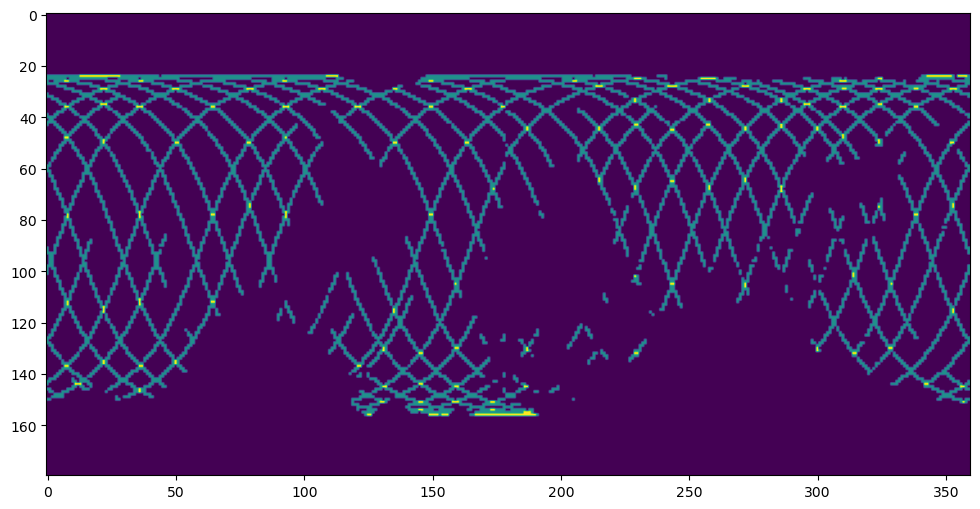

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.imshow(np.sum( ds_new['avail'].data + 0. , axis=0 )[100,:,:].squeeze() )
pl

